In [1]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

import numpy as np
import cv2
import os
import random

import pandas as pd

from typing import Tuple, List, Dict, Optional
from collections import OrderedDict

import matplotlib.pyplot as plt
import seaborn as sns

## COCO API

In [2]:
# COCO annotation file load
root_path = '/data/ephemeral/dataset/'

coco = COCO(os.path.join(root_path, 'train.json'))
coco

loading annotations into memory...
Done (t=0.15s)
creating index...
index created!


In [ ]:
# image_id
image_id = coco.getImgIds()

# image_information (by image_id)
img_info = coco.loadImgs(image_id)

# annotation id (by image_id)
ann_ids = coco.getAnnIds(imgIds=image_id)

# get anntation (by annotation_id)
anns = coco.loadAnns(ann_ids)

print(anns)

## 훈련 데이터 시각화

In [4]:
import cv2
import os
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import numpy as np

classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

# 새롭게 제안된 색상 팔레트
colors = [
    (255, 0, 0),      # 빨강 (General trash)
    (0, 255, 0),      # 초록 (Paper)
    (0, 0, 255),      # 파랑 (Paper pack)
    (255, 255, 0),    # 노랑 (Metal)
    (255, 165, 0),    # 주황 (Glass)
    (0, 255, 255),    # 청록 (Plastic)
    (0, 0, 0),    # 검정 (Styrofoam)
    (255, 20, 147),   # DeepPink (Plastic bag)
    (0, 128, 0),      # 진한 초록 (Battery)
    (255, 192, 203)   # 핑크 (Clothing)
]

# 클래스 ID와 색상을 매핑
class_colors = {class_name: colors[i] for i, class_name in enumerate(classes)}

def draw_legend(class_colors, classes):
    # 팔레트를 나타낼 빈 공간 생성 (500px 높이)
    legend_img = np.ones((1024, 200, 3), dtype=np.uint8) * 255  # 흰색 배경
    for idx, class_name in enumerate(classes):
        color = class_colors[class_name]
        y_pos = 20 + idx * 40  # 각 레이블마다 40px 간격
        cv2.rectangle(legend_img, (10, y_pos), (40, y_pos + 30), color, -1)  # 색상 막대
        cv2.putText(legend_img, class_name, (50, y_pos + 25), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2, cv2.LINE_AA)  # 레이블 텍스트
    return legend_img

def show_one_image(image_id, save_path=None):
    root_path = '/data/ephemeral/dataset/'
    coco = COCO(os.path.join(root_path, 'train.json'))
    
    # 이미지 정보 불러오기
    img_info = coco.loadImgs(image_id)[0]
    ann_ids = coco.getAnnIds(imgIds=image_id)
    anns = coco.loadAnns(ann_ids)

    # 이미지 불러오기
    img = cv2.imread(root_path + img_info['file_name'])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for ann in anns:
        # 카테고리 ID와 bbox 추출
        label_id = ann['category_id']
        bbox = ann['bbox']
        
        # COCO format에서는 bbox가 [x, y, width, height]이므로 변환
        xmin, ymin, width, height = bbox
        xmax = xmin + width
        ymax = ymin + height

        # 좌표를 정수형으로 변환
        xmin, ymin, xmax, ymax = map(int, [xmin, ymin, xmax, ymax])

        # 카테고리 ID에 맞는 클래스명을 가져옴
        label = coco.cats[label_id]['name']

        # 색상 매칭 (일부 카테고리 ID는 classes 인덱스를 넘어갈 수 있음)
        if label in class_colors:
            color = class_colors[label]
        else:
            color = (255, 255, 255)  # 기본 색상 (하얀색) 적용
        
        # Bounding Box 그리기
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color=color, thickness=2)

    # 색상 팔레트 레이블을 그리는 이미지 생성
    legend_img = draw_legend(class_colors, classes)

    # 이미지를 시각화 (오른쪽에 레이블 포함)
    combined_img = np.hstack((img, legend_img))  # 이미지 옆에 팔레트 추가
    plt.figure(figsize=(16, 12))
    plt.imshow(combined_img)
    plt.axis('off')

    plt.show()


loading annotations into memory...
Done (t=0.17s)
creating index...
index created!


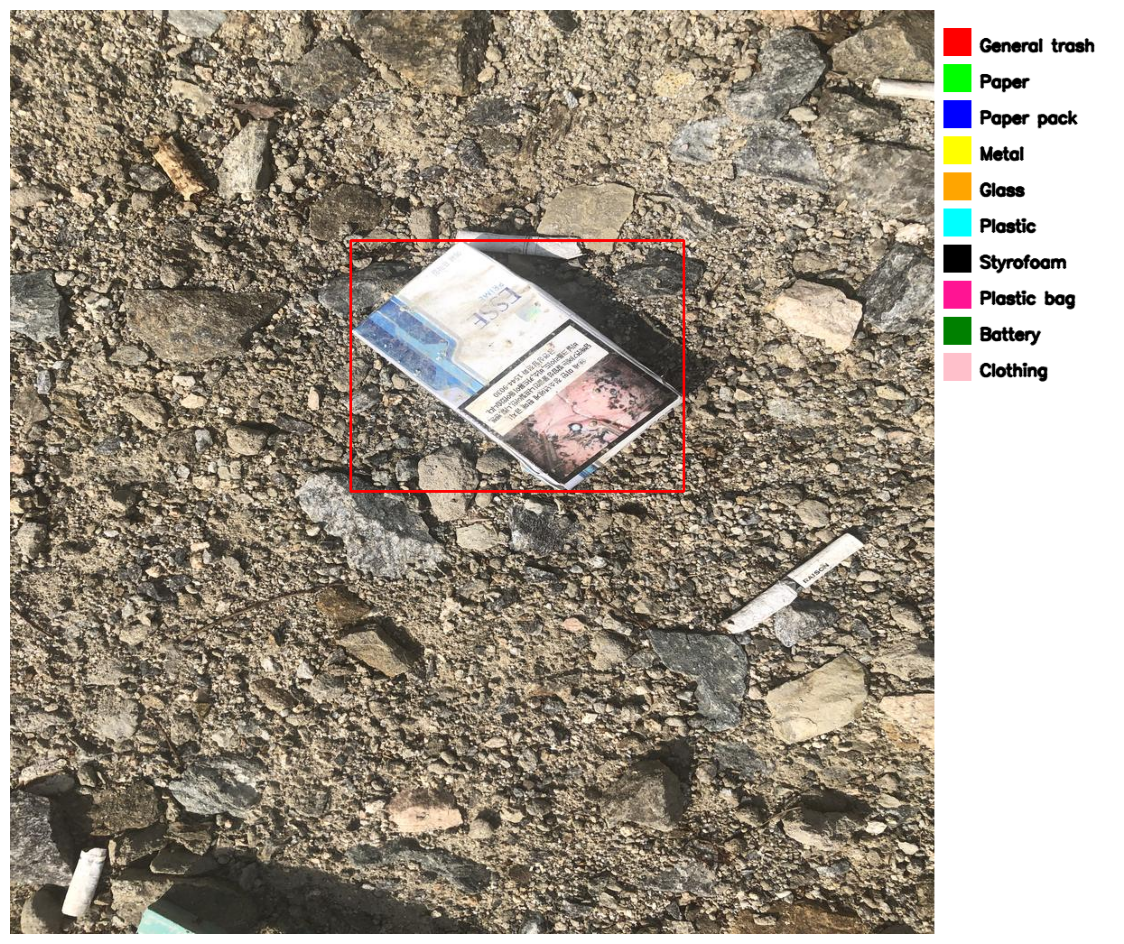

In [5]:
show_one_image(image_id=10)

## 데이터셋 각 카테고리별 개수 분포
- class imbalance 문제 존재함
- 가장 많은 카테고리인 paper 대비, 가장 적은 battery는 거의 대략 30배 차이

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


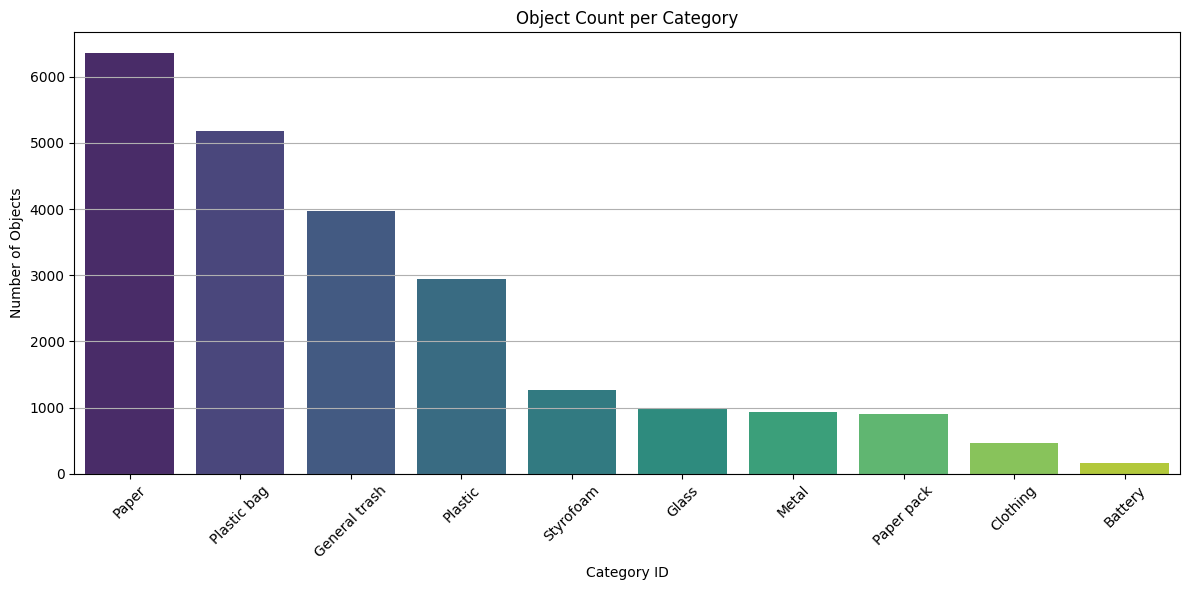

In [6]:
# COCO 데이터셋 로드
root_path = '/data/ephemeral/dataset/'
coco = COCO(os.path.join(root_path, 'train.json'))

# 각 카테고리의 객체 수를 세기 위한 딕셔너리
category_counts = {}

# 모든 annotation에 대해 loop
for ann in coco.anns.values():
    category_id = classes[ann['category_id']]  # 카테고리 ID
    if category_id not in category_counts:
        category_counts[category_id] = 0
    category_counts[category_id] += 1

# 카테고리 ID를 키로 하는 DataFrame으로 변환

category_df = pd.DataFrame(list(category_counts.items()), columns=['Category ID', 'Count'])
category_df = category_df.sort_values(by='Count', ascending=False)  # 카운트 기준 정렬

# 바 차트 생성
plt.figure(figsize=(12, 6))
sns.barplot(x='Category ID', y='Count', data=category_df, palette='viridis')

# 레이블 및 타이틀
plt.xlabel('Category ID')
plt.ylabel('Number of Objects')
plt.title('Object Count per Category')
plt.xticks(rotation=45)  # x축 레이블 회전
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## 이미지 해상도 분석
- 1024x1024 고정이네..?

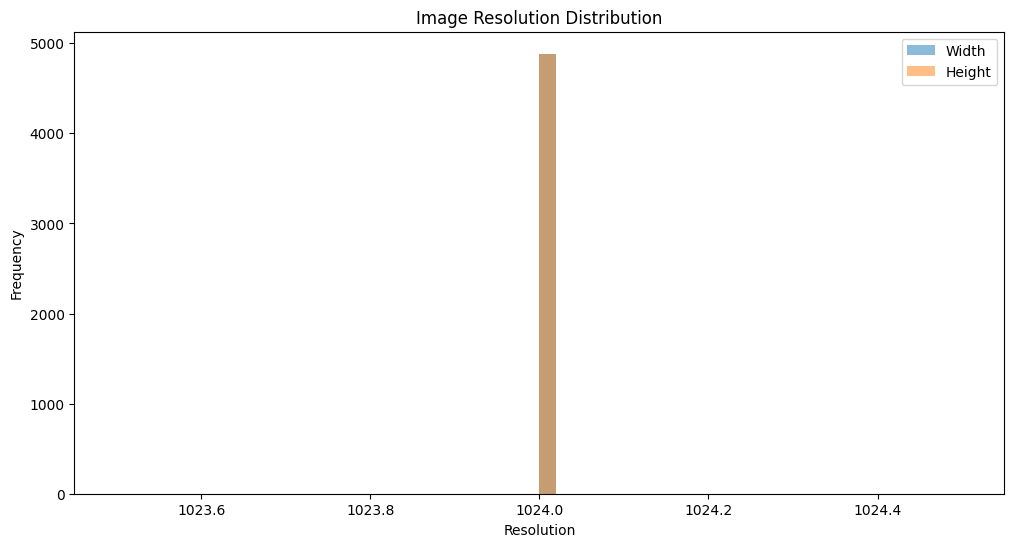

In [7]:
# 해상도 리스트
resolutions = []

# 모든 이미지에 대해 해상도 추출
for img_id in coco.imgs.keys():
    img_info = coco.imgs[img_id]
    resolutions.append((img_info['width'], img_info['height']))

# 해상도 분포 시각화
widths, heights = zip(*resolutions)

plt.figure(figsize=(12, 6))
plt.hist(widths, bins=50, alpha=0.5, label='Width')
plt.hist(heights, bins=50, alpha=0.5, label='Height')
plt.xlabel('Resolution')
plt.ylabel('Frequency')
plt.title('Image Resolution Distribution')
plt.legend()
plt.show()


## 객체 크기 분포
- 대체로 크기 분포가 밀집되어 있는 반면에, General trash와 Paper는 크기가 작은 객체도 포함되어 있음
- 크기가 너무 큰 객체에 대해 이상치로 분류되는데, 이를 고려한 데이터 전처리가 필요함

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


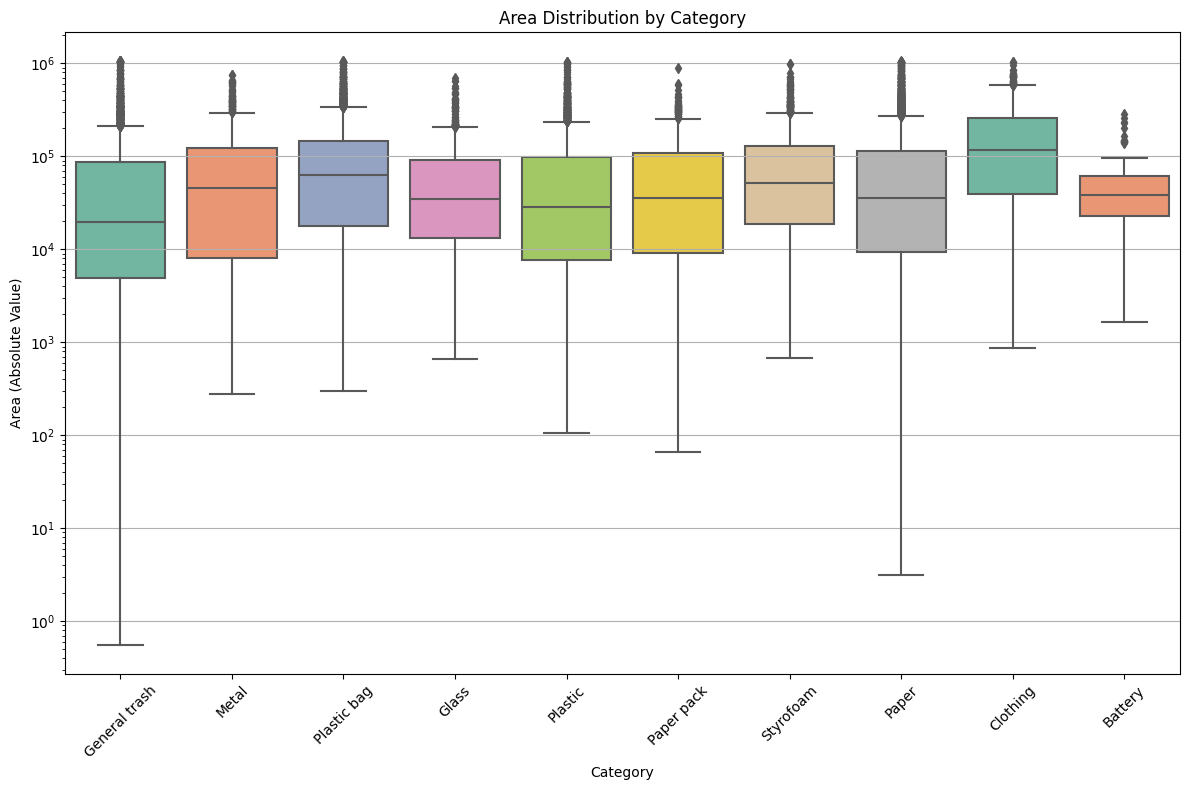

In [8]:
# COCO 데이터셋 로드
root_path = '/data/ephemeral/dataset/'
coco = COCO(os.path.join(root_path, 'train.json'))

# 각 카테고리의 면적을 저장할 딕셔너리
category_areas = {}

# 모든 annotation에 대해 loop
for ann in coco.anns.values():
    category_id = classes[ann['category_id']]
    area = ann['area']
    
    if category_id not in category_areas:
        category_areas[category_id] = []
    
    category_areas[category_id].append(area)

# DataFrame으로 변환
data = []
for category_id, areas in category_areas.items():
    for area in areas:
        data.append({'Category': category_id, 'Area': area})

df = pd.DataFrame(data)

# Seaborn의 boxplot 그리기
plt.figure(figsize=(12, 8))
sns.boxplot(x='Category', y='Area', data=df, palette='Set2')  # 눈에 띄는 팔레트 선택

# 레이블 및 타이틀
plt.ylabel('Area (Absolute Value)')  # y축 레이블 변경
plt.yscale('log')  # 로그 스케일로 변경 (필요시)
plt.title('Area Distribution by Category')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


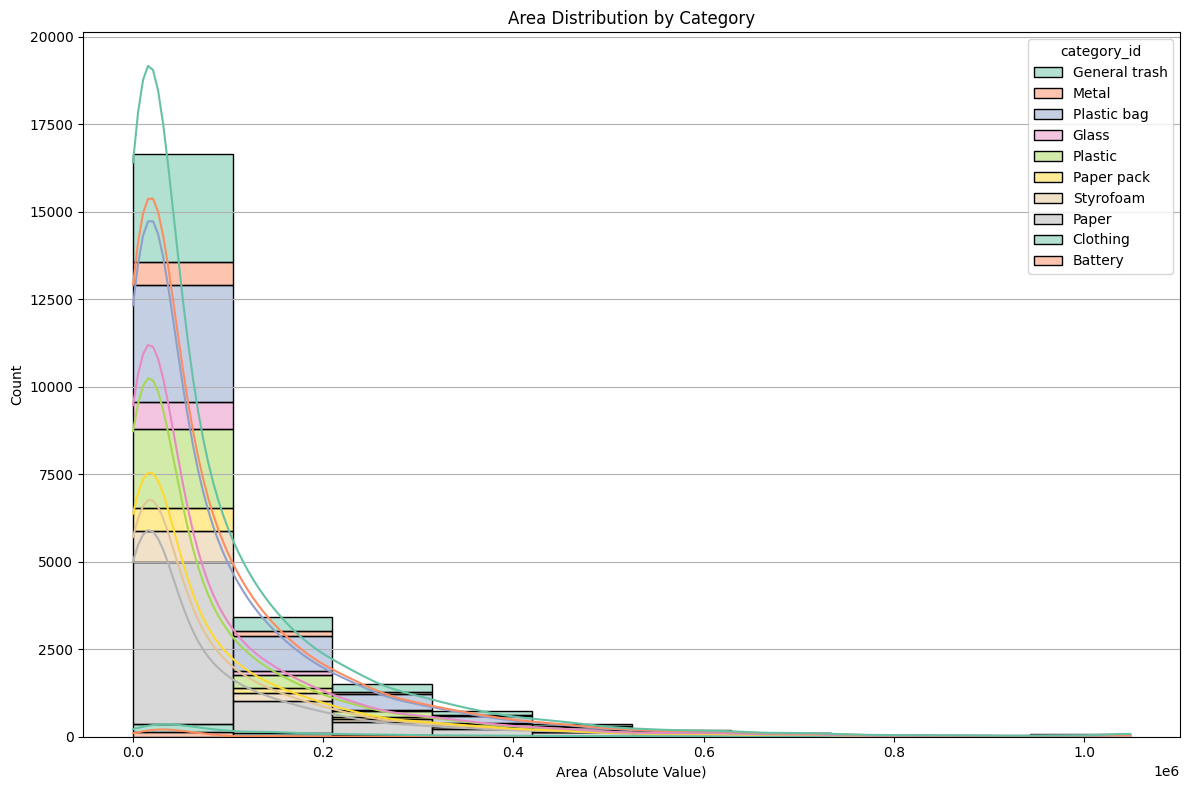

In [9]:
# COCO 데이터셋 로드
root_path = '/data/ephemeral/dataset/'
coco = COCO(os.path.join(root_path, 'train.json'))

# 각 카테고리의 면적을 저장할 리스트
data = []

# 모든 annotation에 대해 loop
for ann in coco.anns.values():
    category_id = classes[ann['category_id']]
    area = ann['area']
    data.append({'category_id': category_id, 'area': area})

# DataFrame으로 변환
df = pd.DataFrame(data)

# 히스토그램 그리기
plt.figure(figsize=(12, 8))

# Seaborn의 히스토그램을 사용하여 카테고리별로 면적 분포 그리기
sns.histplot(data=df, x='area', hue='category_id', multiple='stack', bins=10, palette='Set2', kde=True)

# 레이블 및 타이틀
plt.xlabel('Area (Absolute Value)')
plt.ylabel('Count')
plt.title('Area Distribution by Category')
# plt.xscale('log')  # 로그 스케일로 변경 (필요시)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## 객체 가로:세로 비율 분포
- 대체로 1:1 비율의 박스를 그림
- 가로 비율이 과하게 큰 몇몇 박스가 존재함

loading annotations into memory...
Done (t=0.19s)
creating index...
index created!
       Aspect Ratio
count  23144.000000
mean       1.298707
std        1.166790
min        0.055391
25%        0.691147
50%        1.047518
75%        1.537306
max       27.285714


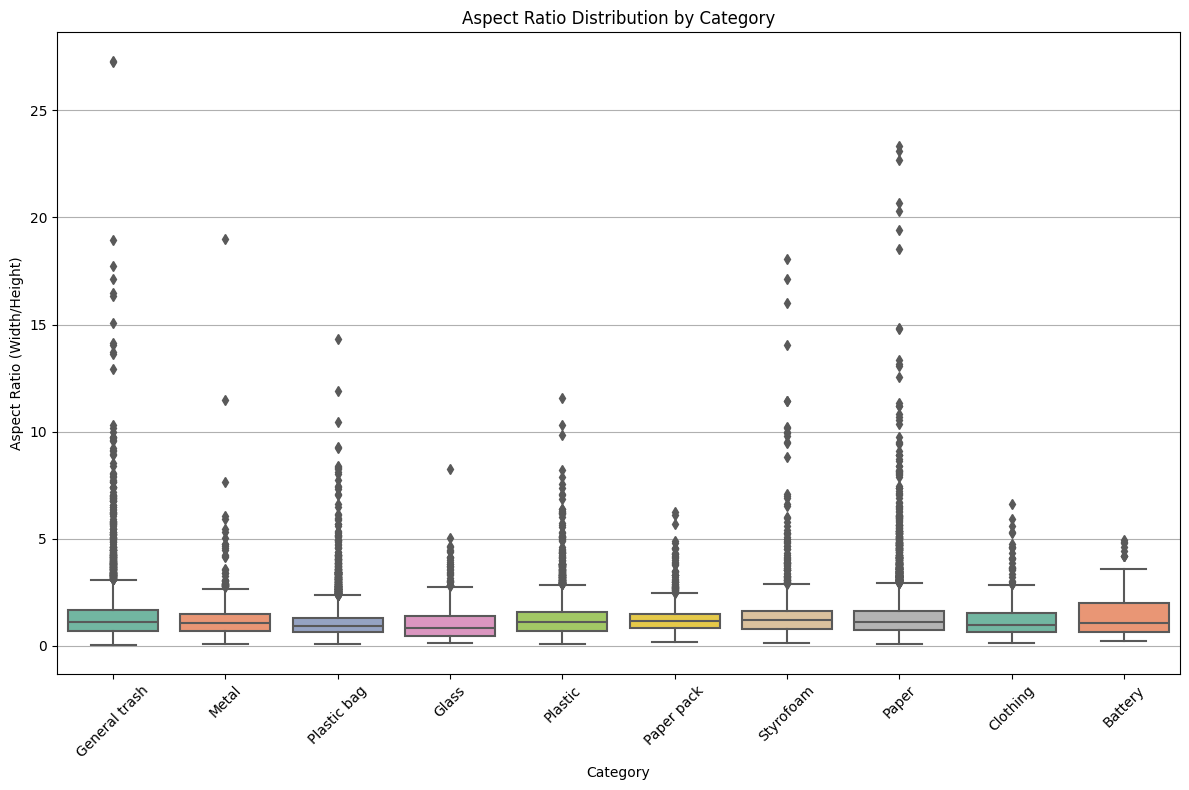

In [10]:
# COCO 데이터셋 로드
root_path = '/data/ephemeral/dataset/'
coco = COCO(os.path.join(root_path, 'train.json'))

# 각 카테고리의 가로 세로 비율을 저장할 딕셔너리
category_aspect_ratios = {}

# 모든 annotation에 대해 loop
for ann in coco.anns.values():
    category_id = classes[ann['category_id']]
    bbox = ann['bbox']  # [xmin, ymin, width, height]
    width, height = bbox[2], bbox[3]  # width와 height 추출
    aspect_ratio = width / height  # 가로 세로 비율 계산
    
    if category_id not in category_aspect_ratios:
        category_aspect_ratios[category_id] = []
    
    category_aspect_ratios[category_id].append(aspect_ratio)

# DataFrame으로 변환
data = []
for category_id, aspect_ratios in category_aspect_ratios.items():
    for aspect_ratio in aspect_ratios:
        data.append({'Category': category_id, 'Aspect Ratio': aspect_ratio})

df = pd.DataFrame(data)
print(df.describe())

# Seaborn의 boxplot 그리기
plt.figure(figsize=(12, 8))
sns.boxplot(x='Category', y='Aspect Ratio', data=df, palette='Set2')  # 눈에 띄는 팔레트 선택

# 레이블 및 타이틀
plt.ylabel('Aspect Ratio (Width/Height)')  # y축 레이블
plt.title('Aspect Ratio Distribution by Category')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## 이미지 당 포함하고 있는 객체 개수
- 대체로 적은 객체를 포함하고 있음 1~2개가 가장 많고, 평균값이 4 정도
- 근데, 71개를 포함하고 있는 데이터도 존재함 이를 어떻게 처리할지?

loading annotations into memory...
Done (t=0.20s)
creating index...
index created!
       Object Count
count   4883.000000
mean       4.739709
std        6.355155
min        1.000000
25%        1.000000
50%        2.000000
75%        6.000000
max       71.000000


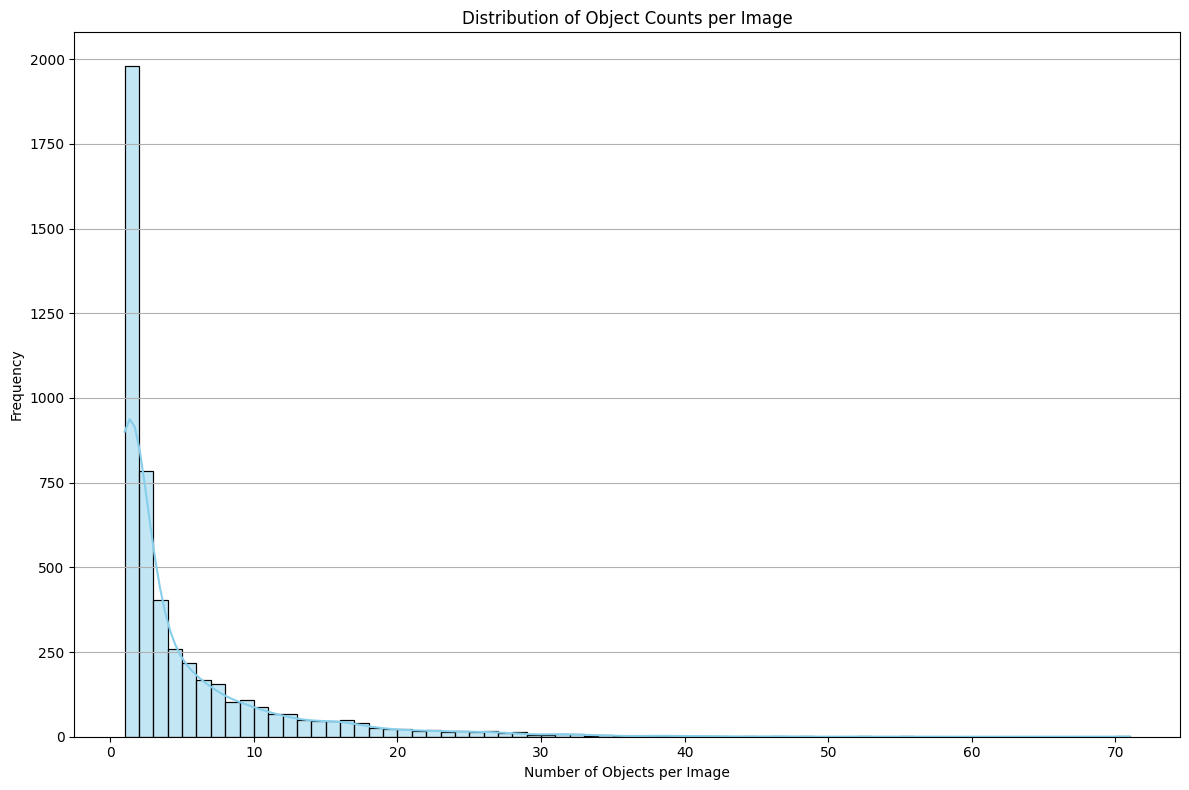

In [11]:
# COCO 데이터셋 로드
root_path = '/data/ephemeral/dataset/'
coco = COCO(os.path.join(root_path, 'train.json'))

# 각 이미지별 객체 개수를 저장할 리스트
image_object_counts = []

# 모든 annotation에 대해 loop
for img_id in coco.imgs.keys():
    annotations = coco.getAnnIds(imgIds=img_id)  # 현재 이미지에 대한 annotation ID 가져오기
    object_count = len(annotations)  # 객체 개수 카운트
    image_object_counts.append(object_count)  # 리스트에 추가

# 객체 개수 데이터프레임 생성
df_counts = pd.DataFrame(image_object_counts, columns=['Object Count'])

print(df_counts.describe())

# Seaborn으로 분포 시각화
plt.figure(figsize=(12, 8))
sns.histplot(df_counts['Object Count'], bins=70, kde=True, color='skyblue')  # 히스토그램과 커널 밀도 추정

# 레이블 및 타이틀
plt.xlabel('Number of Objects per Image')
plt.ylabel('Frequency')
plt.title('Distribution of Object Counts per Image')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


## 객체 데이터 상 위치 좌표 히트맵 분석
- 오른쪽 아래에 약간 치우쳐진 분포를 보임

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


/tmp/ipykernel_927006/4059080380.py:79: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


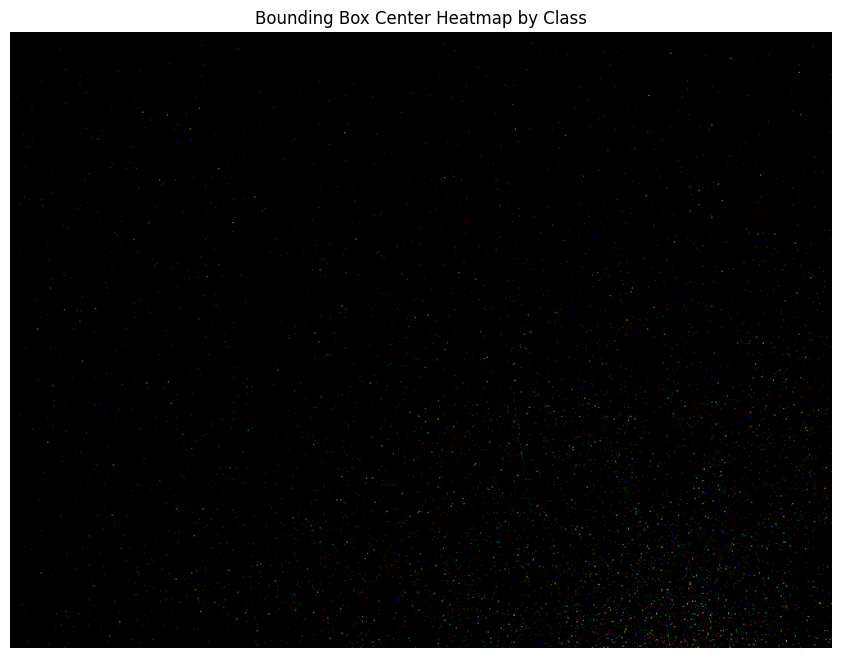

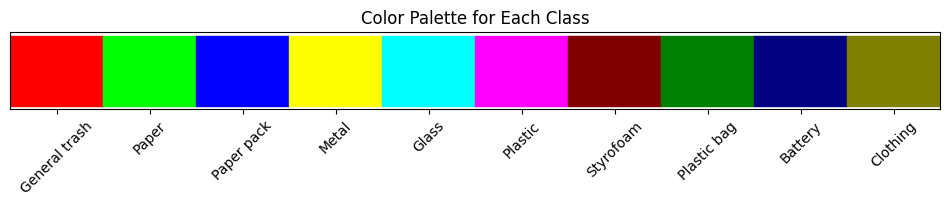

In [12]:
# COCO 데이터셋 로드
root_path = '/data/ephemeral/dataset/'
coco = COCO(os.path.join(root_path, 'train.json'))

# 이미지의 크기 설정 (원하는 크기로 변경)
img_width, img_height = 640, 480

# 클래스와 색상 정의
classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

# 색상 설정 (임의로 설정)
colors = [
    (255, 0, 0),      # Red
    (0, 255, 0),      # Green
    (0, 0, 255),      # Blue
    (255, 255, 0),    # Yellow
    (0, 255, 255),    # Cyan
    (255, 0, 255),    # Magenta
    (128, 0, 0),      # Maroon
    (0, 128, 0),      # Dark Green
    (0, 0, 128),      # Navy
    (128, 128, 0)     # Olive
]

# 클래스별 히트맵 초기화
heatmaps = {class_name: np.zeros((img_height, img_width)) for class_name in classes}

# 모든 annotation에 대해 loop
for ann in coco.anns.values():
    # 바운딩 박스 좌표
    xmin, ymin, width, height = ann['bbox']
    
    # 중심 좌표 계산
    center_x = int(xmin + width / 2)
    center_y = int(ymin + height / 2)

    # 클래스 ID에 맞는 색상 및 클래스 이름
    category_id = ann['category_id']
    class_name = classes[category_id]

    # 히트맵 업데이트 (각 바운딩 박스의 중심 위치에 값 추가)
    if 0 <= center_x < img_width and 0 <= center_y < img_height:
        heatmaps[class_name][center_y, center_x] += 1

# 히트맵 합치기
combined_heatmap = np.zeros((img_height, img_width, 3), dtype=np.uint8)

for i, class_name in enumerate(classes):
    # 색상 변환
    color = colors[i]
    
    # 현재 클래스 히트맵
    current_heatmap = heatmaps[class_name]
    
    # 색상으로 변환
    colored_heatmap = np.zeros((img_height, img_width, 3), dtype=np.uint8)
    colored_heatmap[:, :, 0] = current_heatmap * color[0] // np.max(current_heatmap)  # Red channel
    colored_heatmap[:, :, 1] = current_heatmap * color[1] // np.max(current_heatmap)  # Green channel
    colored_heatmap[:, :, 2] = current_heatmap * color[2] // np.max(current_heatmap)  # Blue channel
    
    # 합치기
    combined_heatmap = cv2.addWeighted(combined_heatmap, 1, colored_heatmap, 0.5, 0)

# 히트맵 시각화
plt.figure(figsize=(12, 8))
plt.imshow(combined_heatmap)
plt.title('Bounding Box Center Heatmap by Class')
plt.axis('off')  # 축 제거

# 색상 팔레트 시각화 추가
plt.figure(figsize=(12, 1))
for i, color in enumerate(colors):
    plt.fill_between([i, i+1], 0, 1, color=np.array(color) / 255)
plt.xlim(0, len(colors))
plt.yticks([])
plt.xticks(np.arange(len(classes)) + 0.5, classes, rotation=45)
plt.title('Color Palette for Each Class')
plt.tight_layout()
plt.show()


loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


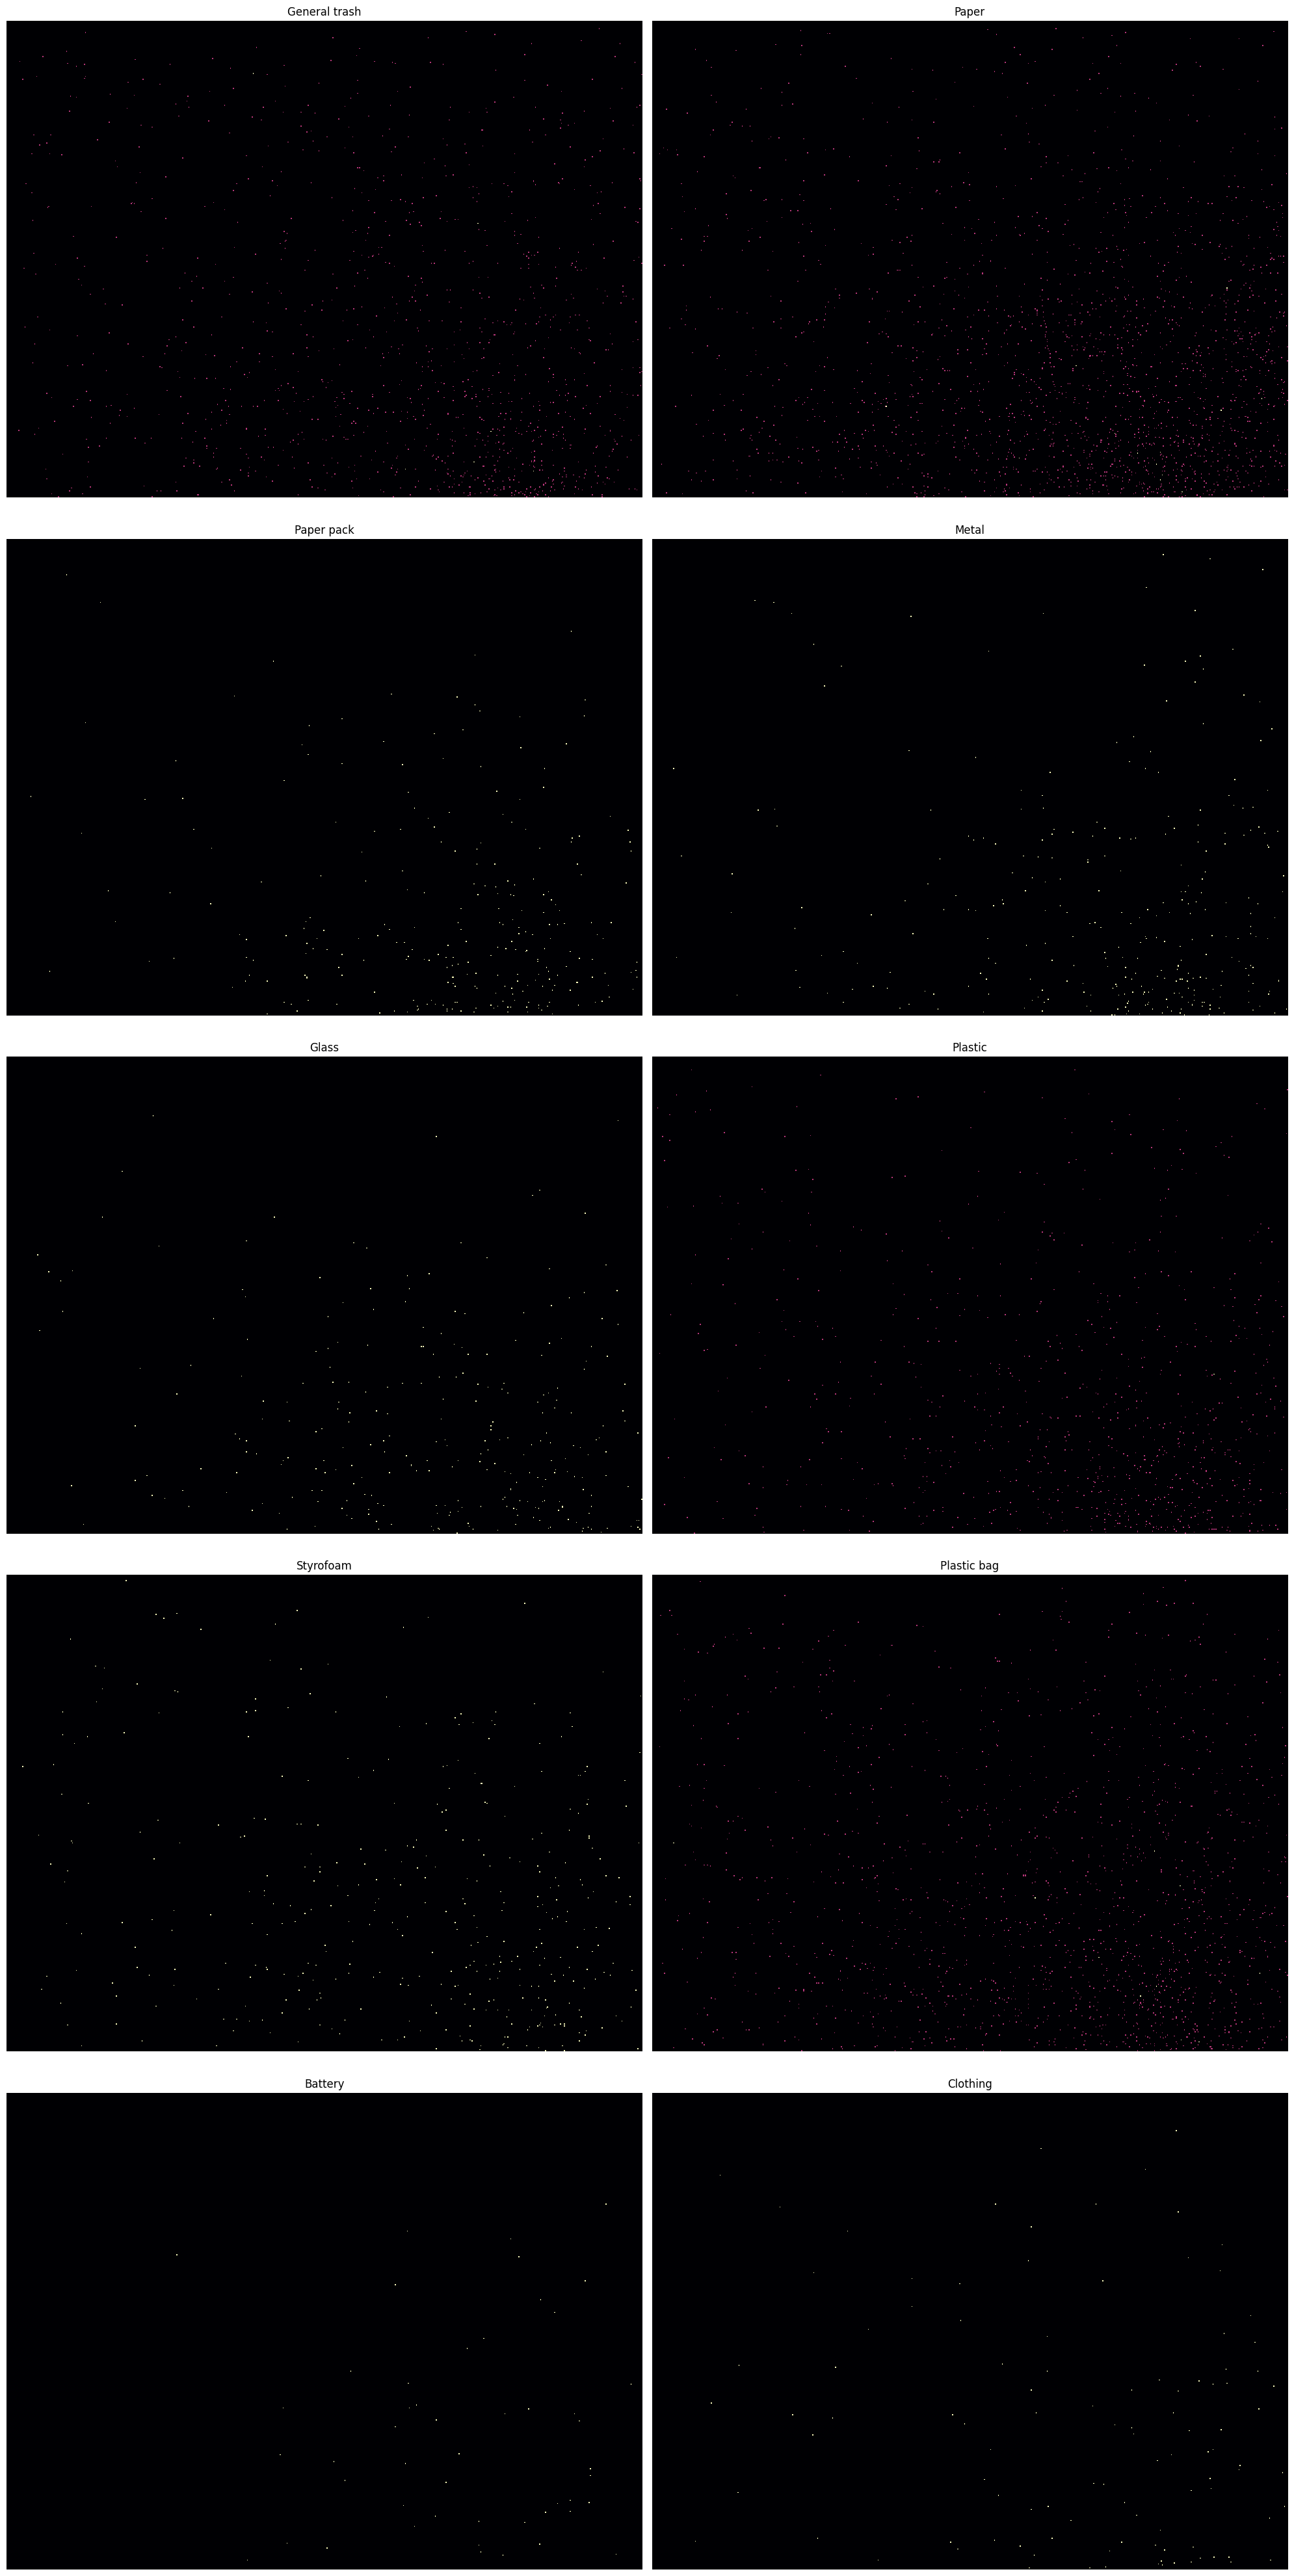

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
import cv2

# COCO 데이터셋 로드
root_path = '/data/ephemeral/dataset/'
coco = COCO(os.path.join(root_path, 'train.json'))

# 이미지의 크기 설정 (원하는 크기로 변경)
img_width, img_height = 640, 480

# 클래스와 색상 정의
classes = ("General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

# 색상 설정 (임의로 설정)
colors = [
    (255, 0, 0),      # Red
    (0, 255, 0),      # Green
    (0, 0, 255),      # Blue
    (255, 255, 0),    # Yellow
    (0, 255, 255),    # Cyan
    (255, 0, 255),    # Magenta
    (128, 0, 0),      # Maroon
    (0, 128, 0),      # Dark Green
    (0, 0, 128),      # Navy
    (128, 128, 0)     # Olive
]

# 각 클래스별 히트맵 초기화
heatmaps = {class_name: np.zeros((img_height, img_width)) for class_name in classes}

# 모든 annotation에 대해 loop
for ann in coco.anns.values():
    # 바운딩 박스 좌표
    xmin, ymin, width, height = ann['bbox']
    
    # 중심 좌표 계산
    center_x = int(xmin + width / 2)
    center_y = int(ymin + height / 2)

    # 클래스 ID에 맞는 색상 및 클래스 이름
    category_id = ann['category_id']
    class_name = classes[category_id]

    # 히트맵 업데이트 (각 바운딩 박스의 중심 위치에 값 추가)
    if 0 <= center_x < img_width and 0 <= center_y < img_height:
        heatmaps[class_name][center_y, center_x] += 1

# 개별 히트맵 시각화
plt.figure(figsize=(20, 40))

for i, class_name in enumerate(classes):
    plt.subplot(5, 2, i + 1)  # 2행 5열의 서브플롯
    plt.imshow(heatmaps[class_name], cmap='magma', interpolation='nearest')
    plt.title(class_name)
    plt.axis('off')  # 축 제거

plt.tight_layout()
plt.show()


## 같은 이미지 상 특정 객체 동시 출현 빈도 분석
- paper와 plastic bag은 한 이미지에 다수 출현하는 빈도가 있는 편
- paper와 plastic bag이 같이 출현하는 경우도 꽤 있어보임

loading annotations into memory...
Done (t=0.22s)
creating index...
index created!


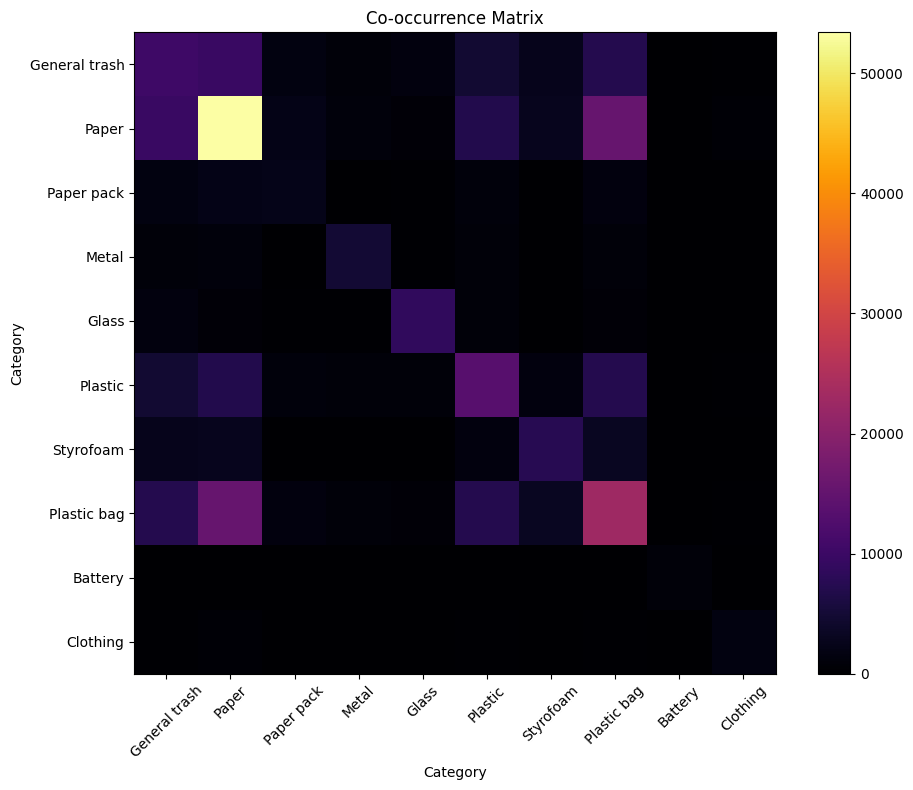

In [14]:
# COCO 데이터셋 로드
root_path = '/data/ephemeral/dataset/'
coco = COCO(os.path.join(root_path, 'train.json'))

# 클래스 정의
classes = ["General trash", "Paper", "Paper pack", "Metal", "Glass", 
           "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

# 공동 출현 빈도 카운트
co_occurrence = np.zeros((len(classes), len(classes)))

# 모든 annotation에 대해 loop
for img_id in coco.imgs.keys():
    ann_ids = coco.getAnnIds(imgIds=img_id)
    category_ids = [coco.anns[ann_id]['category_id'] for ann_id in ann_ids]
    
    # 카테고리 쌍의 출현 카운트
    for i in range(len(category_ids)):
        for j in range(len(category_ids)):
            if i != j:
                co_occurrence[category_ids[i]][category_ids[j]] += 1

# 히트맵으로 시각화
plt.figure(figsize=(10, 8))
plt.imshow(co_occurrence, cmap='inferno', interpolation='nearest')
plt.colorbar()
plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)
plt.title('Co-occurrence Matrix')
plt.xlabel('Category')
plt.ylabel('Category')
plt.tight_layout()
plt.show()
